In [1]:
class Task:
    def __init__(self, task_id, items_count, max_weight, min_price):
        self.task_id = task_id
        self.item_count = items_count
        self.max_weight = max_weight
        self.min_price = min_price
        self.items = [] #Item is list [weight, price]
        self.solution = None
        self.optimal_configuration = None
        self.visited_configs = 0
        self.price_sums = []
    def add_item(self, weight, price):
        self.items.append([weight, price])
    def __str__(self):
        task_str = 'Task id: ' + str(self.task_id) + ', items count: ' + str(self.item_count) + ', max weight: ' + str(self.max_weight) + ", min price: " + str(self.min_price) + "\nItems: \n"
        i = 0
        for item in self.items:
            i += 1
            task_str = task_str + 'item n.' + str(i) + ', weight: ' + str(item[0]) + ' price: ' + str(item[1]) + '\n'
        return task_str
    def calculate_weight_price(self, index):
        index = (str(bin(index)))[2:]
        item_num, price, weight = 0, 0, 0
        j = self.item_count - len(index)
        for i in index:
            if i == '1':
                weight += (self.items[j])[0]
                price += (self.items[j])[1]
            j += 1
        return weight, price
    def reset(self):
        visited_configs = 0
    def calculate_price_sums(self):
        for i in range(0, self.item_count):
            sum_price = 0
            for j in range(i, self.item_count):
                sum_price += (self.items[j])[1]
            self.price_sums.append(sum_price)
            
class Configuration:
    def __init__(self, config_id, price, items = []):
        self.config_id = config_id
        self.price = price
        self.items = items

In [2]:
#Function to export task from string to object Task
def export_task(task: str):
    task_splitted = task.split(" ")
    task = Task(abs(int(task_splitted[0])), int(task_splitted[1]), int(task_splitted[2]), int(task_splitted[3]))
    for i in range (4, (task.item_count * 2) + 4, 2):
        task.add_item(int(task_splitted[i]), int(task_splitted[i+1]))
    task.calculate_price_sums()
    return task

def export_solution(solution: str):
    solution = solution.split(" ")
    config = Configuration(abs(int(solution[0])), int(solution[2]))
    for item in solution[3:]:
        if item == '1': 
            config.items.append(True)
        else:
            config.items.append(False)
    return config

In [3]:
#Function which as input get file with tasks and returns list of objects Task

def read_tasks(file_name: str, solution_file: str = None):
    f = open(file_name)
    tasks_str = f.read()
    tasks_list = tasks_str.split('\n')
    tasks_list.pop()
    tasks_obj_list = []
    for task_str in tasks_list:
        task_obj = export_task(task_str)
        tasks_obj_list.append(task_obj)
    f.close()
    if solution_file:
        f2 = open(solution_file)
        solutions_str = f2.read()
        solutions_list = solutions_str.split('\n')
        solutions_list.pop()
        for solution in solutions_list:
            configuration = export_solution(solution)
            cid = configuration.config_id - 1
            tasks_obj_list[cid].optimal_configuration = configuration
            if configuration.price > tasks_obj_list[cid].min_price:
                tasks_obj_list[cid].solution = True
            else:
                tasks_obj_list[cid].solution = False
        f2.close()    
    return tasks_obj_list


In [4]:
def sack_problem_solver_brute_force(task: Task) -> bool:
    index_max = pow(2, task.item_count) - 1
    index = 0
    while index <= index_max:
        task.visited_configs += 1
        weight, price = task.calculate_weight_price(index)
        if price > task.min_price and weight <= task.max_weight:
            return True
        index += 1
    return False

In [5]:
def sack_problem_solver_branch_method_only_weight(task: Task, optimize_by_weight: bool = True, optimize_by_price: bool = False) -> bool:
    if sack_problem_solver_branch_method_rec(task, 0, True, 0, 0, optimize_by_weight, optimize_by_price):
        return True
    return False

def sack_problem_solver_branch_method_only_price(task: Task, optimize_by_weight: bool = False, optimize_by_price: bool = True) -> bool:
    if sack_problem_solver_branch_method_rec(task, 0, True, 0, 0, optimize_by_weight, optimize_by_price):
        return True
    return False

def sack_problem_solver_branch_method(task: Task, optimize_by_weight: bool = True, optimize_by_price: bool = True) -> bool:
    if sack_problem_solver_branch_method_rec(task, 0, True, 0, 0, optimize_by_weight, optimize_by_price):
        return True
    return False

def sack_problem_solver_branch_method_rec(task: Task, pos: int, add_item: bool, weight: int, price: int, optimize_by_weight: bool = True, optimize_by_price: bool = True):
    if pos == task.item_count:
        task.visited_configs += 1
        if price > task.min_price and weight <= task.max_weight:
            return True
        else:
            return False
    else:
        new_weight = weight + (task.items[pos])[0]
        new_price = price + (task.items[pos])[1]
        
        if optimize_by_weight:
            if weight > task.max_weight: 
                task.visited_configs += 1
                return False

        if optimize_by_price:
            if (price + task.price_sums[pos]) < task.min_price:
                task.visited_configs += 1
                return False
        
        
        if sack_problem_solver_branch_method_rec(task, pos + 1, True, new_weight, new_price, optimize_by_weight, optimize_by_price):
            return True
        if sack_problem_solver_branch_method_rec(task, pos + 1, False, weight, price, optimize_by_weight, optimize_by_price):
            return True
        
        return False

In [6]:
from typing import Callable

def run_solver(task_file: str, repeat_num: int, solver: Callable, solution_file: str = None):
    tasks = read_tasks(task_file, solution_file)
    same = 0
    different = 0
    visited_configs = 0
    max_visited = None
    for task in tasks:
        solution = solver(task)
        if solution == task.solution or not (solution_file):
            same += 1
        else:
            different += 1
            print(task.task_id, solution, task.solution)
        visited_configs += task.visited_configs
        if max_visited:
            if max_visited < task.visited_configs:
                max_visited = task.visited_configs
        else:
            max_visited = task.visited_configs
        task.reset()
    if different > 0:
        print('Something went wrong ...')
        print(same, different)
    avg_visited = visited_configs / len(tasks)
    #print('average visited:', avg_visited, 'max:', max_visited)
    return avg_visited, max_visited

def run_solver_get_values(task_file: str, repeat_num: int, solver: Callable):
    tasks = read_tasks(task_file)
    visited_configs_list = [] 
    i = 0
    for task in tasks:
        #print(i+1, '/', len(tasks))
        i = i+1
        solution = solver(task)
        visited_configs_list.append(task.visited_configs)
        task.reset()
    return visited_configs_list

In [7]:
#run_solver("./ZR/ZR15_inst.dat", 1, sack_problem_solver_brute_force, "./ZR/ZK15_sol.dat")
#run_solver("./ZR/ZR15_inst.dat", 1, sack_problem_solver_branch_method_only_weight, "./ZR/ZK15_sol.dat")
#run_solver("./ZR/ZR15_inst.dat", 1, sack_problem_solver_branch_method_only_price, "./ZR/ZK15_sol.dat")
#run_solver("./ZR/ZR15_inst.dat", 1, sack_problem_solver_branch_method, "./ZR/ZK15_sol.dat")

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def make_histo(file: str, bins: int, name: str = '', solver: Callable = None):
    values = run_solver_get_values(file, 1, solver)
    num_bins = bins
    n, bins, patches = plt.hist(values, num_bins, facecolor='blue', alpha=0.5)
    plt.xlabel('Počet navštívených konfigurací')
    plt.ylabel('Počet instancí')
    plt.title(name)

    plt.show()
    return

#make_histo("./ZR/ZR20_inst.dat", 12, 'Histogram četnosti jednotlivých hodnot pro n=20')


In [9]:
from tabulate import tabulate

files = []
filesZR = []
algorithms = [sack_problem_solver_brute_force, sack_problem_solver_branch_method_only_weight, sack_problem_solver_branch_method_only_price, sack_problem_solver_branch_method]
#n_list = [4, 10, 15, 20, 22, 25, 27, 30, 32, 35, 37, 40]
n_list = []
for x in n_list:
    file_str = "./NR/NR" + str(x) + "_inst.dat"
    file_str_ZR = "./ZR/ZR" + str(x) + "_inst.dat"
    files.append(file_str)
    filesZR.append(file_str_ZR)
    
max_list = []
avg_list = []
tables = []
tablesZR = []
for x in algorithms:
    tables.append([])
    tablesZR.append([])

for i in range(0, len(n_list)):
    for j in range(0, len(algorithms)):
        avg_visited, max_visited = run_solver(files[i], 1, algorithms[j])
        tables[j].append([n_list[i], avg_visited, max_visited])
        print(files[i], 'algoritmus č.', j)
        print(tabulate(tables[j], headers = ["number of items", 'average visits', 'maximum visits'], tablefmt = 'fancy_grid'))
    for j in range(0, len(algorithms)):
        avg_visited, max_visited = run_solver(filesZR[i], 1, algorithms[j])
        tablesZR[j].append([n_list[i], avg_visited, max_visited])
        print(filesZR[i], 'algoritmus č.', j)
        print(tabulate(tablesZR[j], headers = ["number of items", 'average visits', 'maximum visits'], tablefmt = 'fancy_grid'))



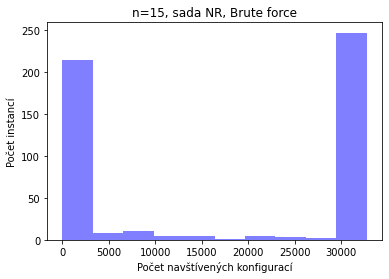

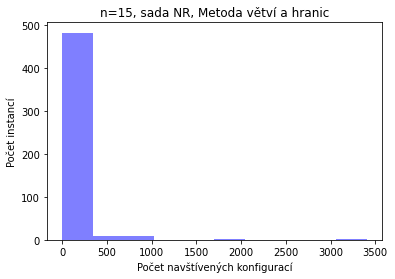

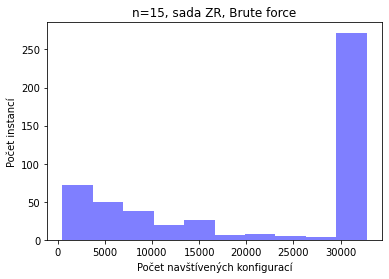

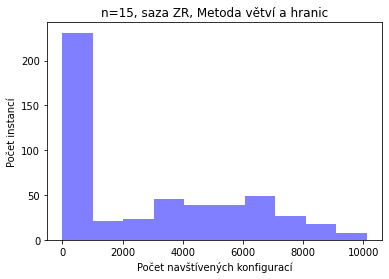

In [10]:
make_histo("./NR/NR15_inst.dat", 10, "n=15, sada NR, Brute force", sack_problem_solver_brute_force)
make_histo("./NR/NR15_inst.dat", 10, 'n=15, sada NR, Metoda větví a hranic', sack_problem_solver_branch_method)
make_histo("./ZR/ZR15_inst.dat", 10, 'n=15, sada ZR, Brute force', sack_problem_solver_brute_force)
make_histo("./ZR/ZR15_inst.dat", 10, 'n=15, saza ZR, Metoda větví a hranic', sack_problem_solver_branch_method)